# Customer Segmentation

###Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_rows', None)

###Load dataset

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Remove missing value
df = df[~(df["CustomerID"].isna())]

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

###Descriptive Statistic

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


The quantity shouldn't be negative number and the unit price mustn't be zero? Let's check it.

###Data Cleaning

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


##Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df.nunique()

InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
dtype: int64

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

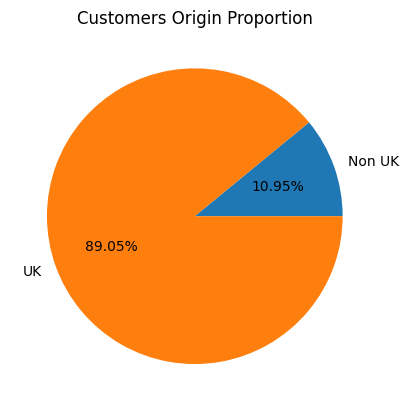

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

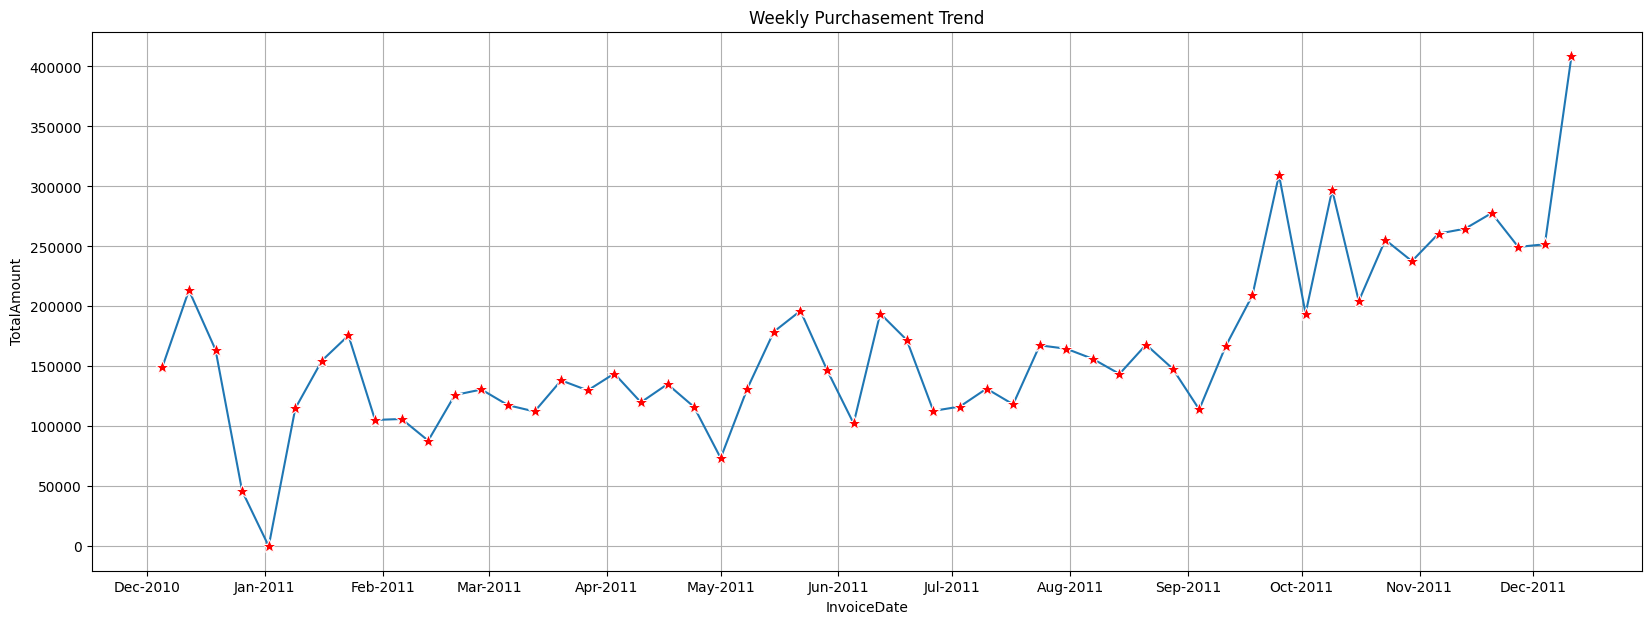

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

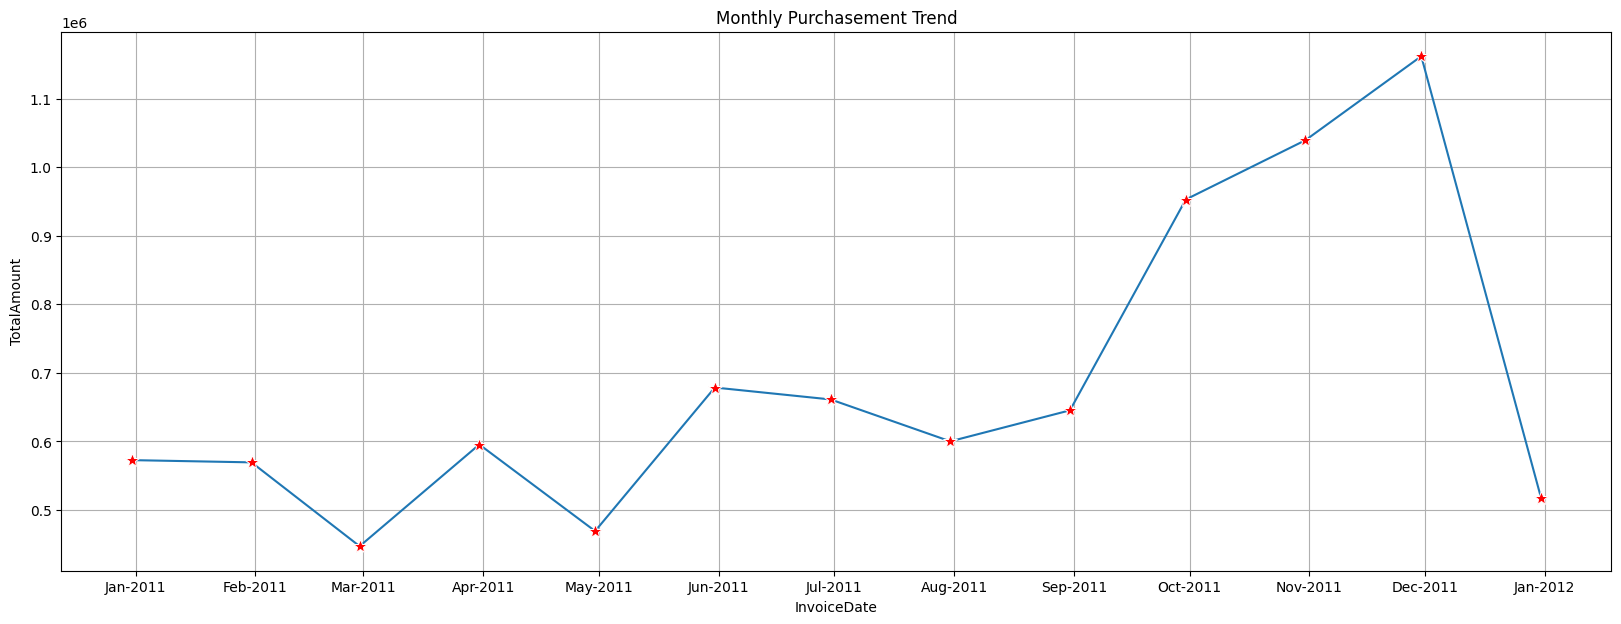

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby("CustomerID")["InvoiceDate"].max()
recency = recency.max() - recency
recency = recency.dt.days
recency = recency.rename("Recency")

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

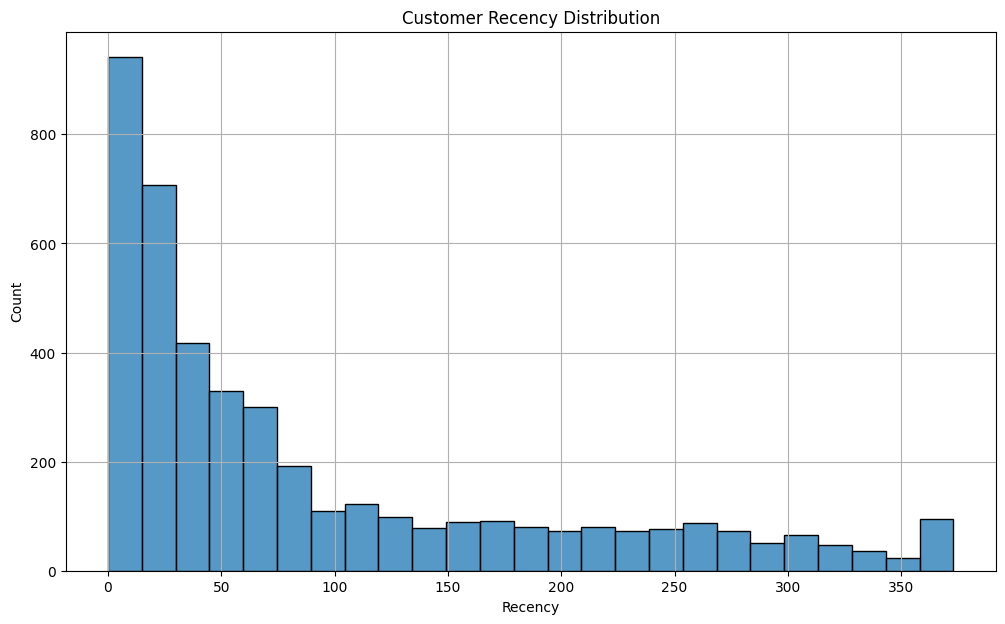

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby("CustomerID")["InvoiceNo"].count()
frequency = frequency.rename("Frequency")

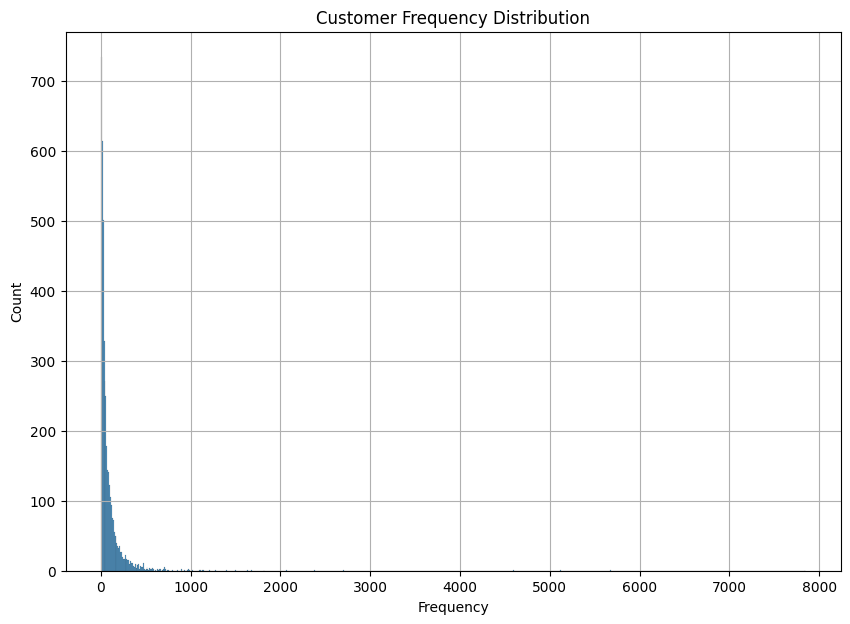

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby("CustomerID")["TotalAmount"].sum()
monetary = monetary.rename("Monetary Spent")

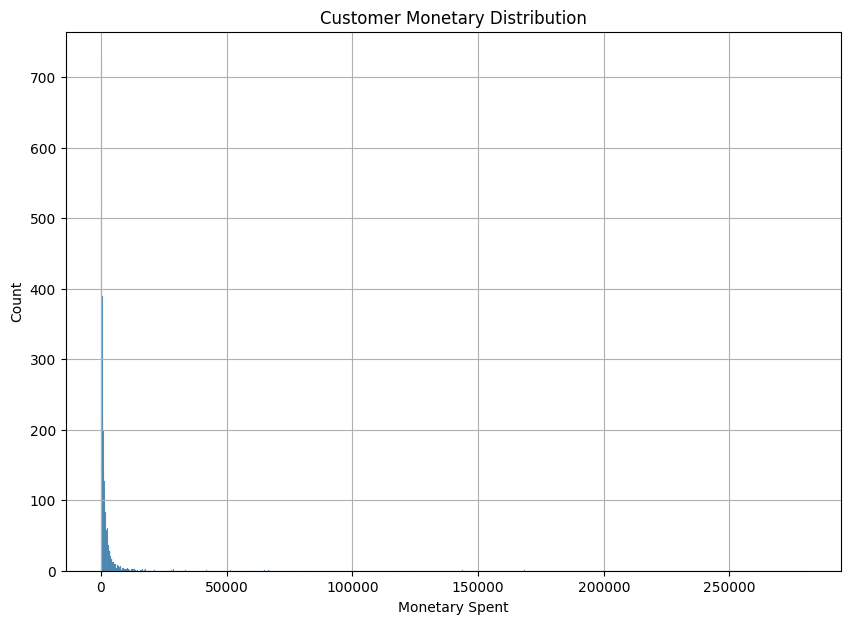

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (country.merge(recency, on="CustomerID").merge(frequency, on="CustomerID").merge(monetary, on="CustomerID"))

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country_isUK    4338 non-null   object 
 1   Recency         4338 non-null   int64  
 2   Frequency       4338 non-null   int64  
 3   Monetary Spent  4338 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 169.5+ KB


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

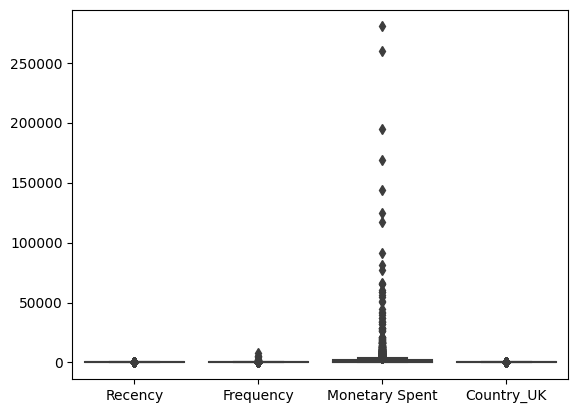

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


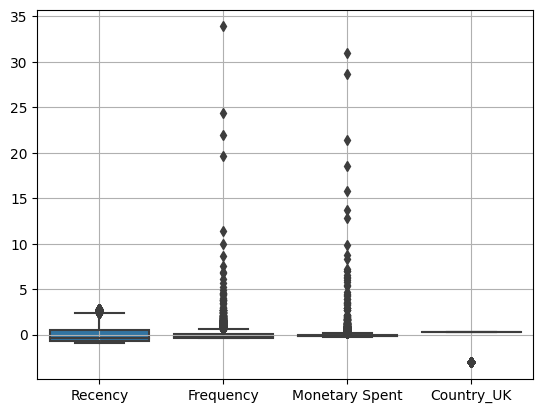

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

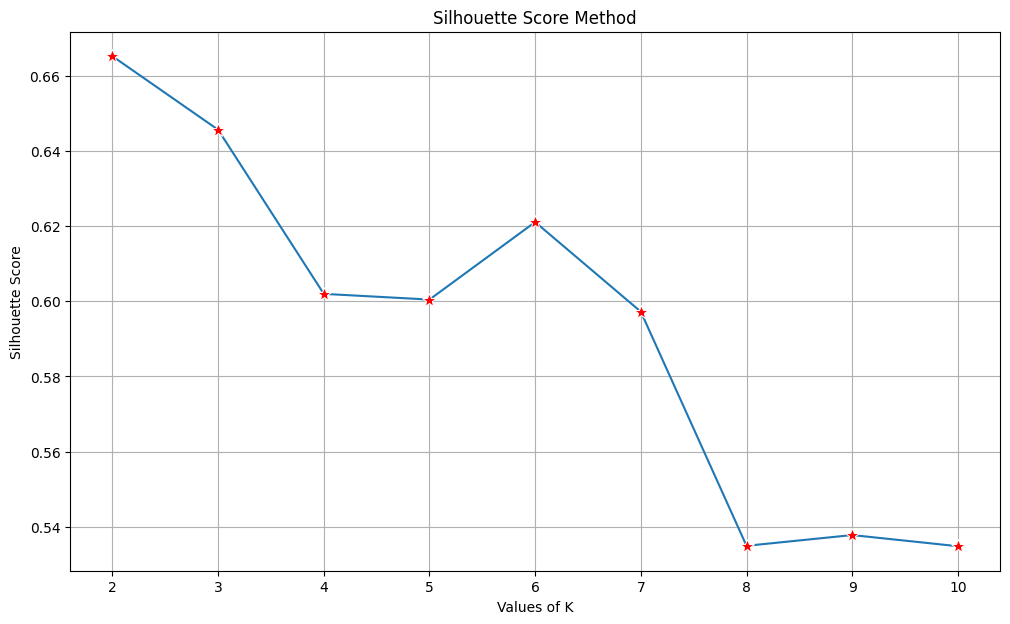

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

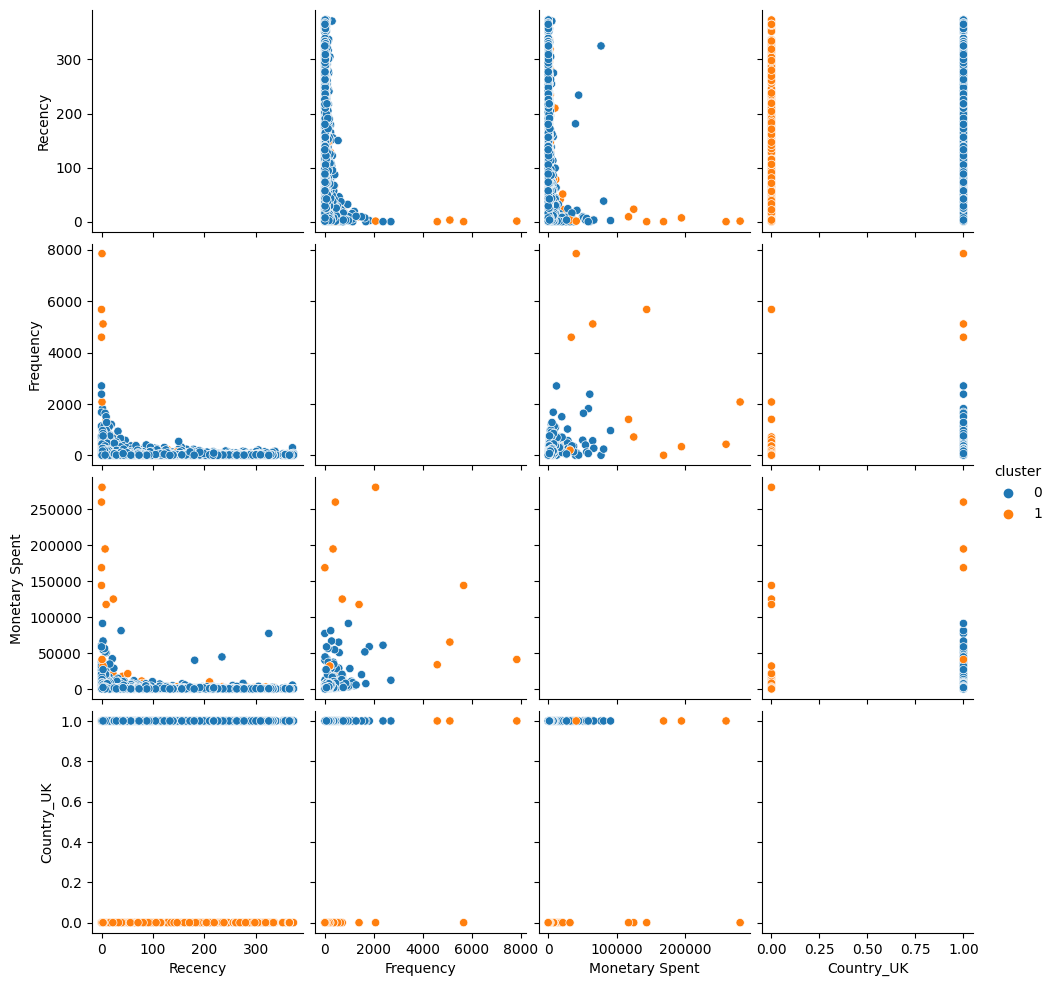

In [ ]:
kmeans = KMeans(n_clusters=2,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0              1
Recency        mean       91.349770      93.259434
               std        99.548570     104.320241
               min         0.000000       0.000000
               q25        17.000000      16.750000
               median     50.000000      50.500000
               q75       142.000000     133.000000
               max       373.000000     373.000000
Frequency      mean       85.844916     145.959906
               std       142.976762     586.766018
               min         1.000000       1.000000
               q25        17.000000      22.000000
               median     41.000000      45.000000
               q75        99.000000     105.000000
               max      2700.000000    7847.000000
Monetary Spent mean     1672.415655    5579.181675
               std      4560.815176   24945.491611
               min         3.750000      51.560000
               q25       300.025000     462.967500
               median    650.430000    1040.780000
               q75      1570.030000    2792.320000
               max     91062.380000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             3914
1        0              418
         1                6
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        1             3914
1        0              418
         1                6
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary Spent"].count()

cluster  Country_UK
0        1             3914
1        0              418
         1                6
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Country_isUK', 'TotalAmount'],
      dtype='object')

In [ ]:
#Top 5 customer dengan pembelian terbanyak

df_1aa = df.groupby("CustomerID")["Quantity"].sum().sort_values()
df_1ab = df.groupby("CustomerID")["InvoiceNo"].count().sort_values()

print("Top 5 pelanggan dengan pembelian item terbanyak :")
print(df_1aa.tail())
print("Top 5 pelanggan yang melakukan pembelian terbanyak :")
print(df_1ab.tail())


Top 5 pelanggan dengan pembelian item terbanyak :
CustomerID
12346.0     74215
12415.0     77374
14911.0     80265
16446.0     80997
14646.0    196915
Name: Quantity, dtype: int64
Top 5 pelanggan yang melakukan pembelian terbanyak :
CustomerID
14606.0    2700
12748.0    4595
14096.0    5111
14911.0    5675
17841.0    7847
Name: InvoiceNo, dtype: int64


In [ ]:
#waktu pembelian dengan jumlah customer terbanyak

df["tahun"] = df["InvoiceDate"].dt.year
df["bulan"] = df["InvoiceDate"].dt.month
df["tanggal"] = df["InvoiceDate"].dt.day
df["hari"] = df["InvoiceDate"].dt.strftime("%A")
df["jam"] = df["InvoiceDate"].dt.hour

for x in ["tahun", "bulan", "tanggal", "hari", "jam"]:
  a = (df.groupby(x)["CustomerID"].count().reset_index()).max()
  if x == "tanggal":
    a[0] = a[0]+1
  print("Waktu pembelian dengan jumlah customer terbanyak "+x,a[0],"dengan jumlah pelanggan sebanyak ", a[1])


Waktu pembelian dengan jumlah customer terbanyak tahun 2011 dengan jumlah pelanggan sebanyak  371727
Waktu pembelian dengan jumlah customer terbanyak bulan 12 dengan jumlah pelanggan sebanyak  64531
Waktu pembelian dengan jumlah customer terbanyak tanggal 32 dengan jumlah pelanggan sebanyak  18346
Waktu pembelian dengan jumlah customer terbanyak hari Wednesday dengan jumlah pelanggan sebanyak  80035
Waktu pembelian dengan jumlah customer terbanyak jam 20 dengan jumlah pelanggan sebanyak  72065


#Jawaban Question 2


In [ ]:
df_result_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         4338 non-null   int64  
 1   Frequency       4338 non-null   int64  
 2   Monetary Spent  4338 non-null   float64
 3   Country_UK      4338 non-null   uint8  
 4   cluster         4338 non-null   int32  
dtypes: float64(1), int32(1), int64(2), uint8(1)
memory usage: 156.7 KB


In [ ]:
df_result_kmeans.head()

,Recency,Frequency,Monetary Spent,Country_UK,cluster
CustomerID,,,,,
12346.0,325,1,77183.60,1,0
12347.0,1,182,4310.00,0,1
12348.0,74,31,1797.24,0,1
12349.0,18,73,1757.55,0,1
12350.0,309,17,334.40,0,1


In [ ]:
df_2 = df_result_kmeans.reset_index()

In [ ]:
df_result_kmeans.loc[(df_result_kmeans["cluster"] == 0),:].count()

Recency           3914
Frequency         3914
Monetary Spent    3914
Country_UK        3914
cluster           3914
dtype: int64

cluster 0 ada 3914 customer

In [ ]:
df_result_kmeans.loc[(df_result_kmeans["cluster"] == 1),:].count()

Recency           424
Frequency         424
Monetary Spent    424
Country_UK        424
cluster           424
dtype: int64

cluster 1 ada 424 customer

In [ ]:
mrgd_df = df.merge(df_2[["CustomerID", "cluster"]], on="CustomerID")
mrgd_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount,tahun,bulan,tanggal,hari,jam,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30,2010,12,1,Wednesday,8,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00,2010,12,1,Wednesday,8,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8,0


In [ ]:
Q2 = mrgd_df.pivot_table(index="Description", columns="cluster", values="CustomerID", aggfunc="nunique")

#5 produk yang dibeli setidaknya 15% dari pelanggan cluster 0
Q2[(Q2[0] > 3914*0.15)]

cluster,0,1
Description,,
ASSORTED COLOUR BIRD ORNAMENT,641.0,37.0
PAPER CHAIN KIT 50'S CHRISTMAS,591.0,22.0
PARTY BUNTING,656.0,52.0
REGENCY CAKESTAND 3 TIER,764.0,117.0
WHITE HANGING HEART T-LIGHT HOLDER,817.0,39.0


In [ ]:
#5 produk yang dibeli setidaknya 30% dari pelanggan cluster 1
Q2[(Q2[1] > 424*0.25)]

cluster,0,1
Description,,
PACK OF 72 RETROSPOT CAKE CASES,528.0,107.0
PLASTERS IN TIN WOODLAND ANIMALS,237.0,114.0
POSTAGE,23.0,308.0
REGENCY CAKESTAND 3 TIER,764.0,117.0
ROUND SNACK BOXES SET OF4 WOODLAND,155.0,126.0


#Jawaban Question 3

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount,tahun,bulan,tanggal,hari,jam
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30,2010,12,1,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00,2010,12,1,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34,2010,12,1,Wednesday,8


In [ ]:
df_nonUK = df[(df["Country_isUK"] == "Non UK")].copy()
df_nonUK.drop(columns = ["Country_isUK", "tahun", "bulan", "tanggal", "hari", "jam"], inplace = True)
df_nonUK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.0
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,10.2
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,15.6


In [ ]:
df_nonUK = df_nonUK.reset_index().drop(columns = "index")
df_nonUK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,10.2
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,15.6


In [ ]:
df_nonUK.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount
count,43563.000000,43563.000000,43563.000000,43563.000000
mean,20.913895,4.356804,13195.460597,36.797657
std,47.964991,43.164338,1085.655986,87.262300
min,1.000000,0.040000,12347.000000,0.190000
25%,6.000000,1.250000,12484.000000,13.200000
50%,12.000000,1.950000,12662.000000,17.700000
75%,18.000000,3.750000,14156.000000,30.000000
max,2400.000000,4161.060000,17844.000000,4992.000000


##Data Exploration

In [ ]:
df_nonUK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43563 entries, 0 to 43562
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    43563 non-null  object        
 1   StockCode    43563 non-null  object        
 2   Description  43563 non-null  object        
 3   Quantity     43563 non-null  int64         
 4   InvoiceDate  43563 non-null  datetime64[ns]
 5   UnitPrice    43563 non-null  float64       
 6   CustomerID   43563 non-null  float64       
 7   Country      43563 non-null  object        
 8   TotalAmount  43563 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 3.0+ MB


In [ ]:
# Check unique value
df_nonUK.nunique()

InvoiceNo      1886
StockCode      2784
Description    2890
Quantity        101
InvoiceDate    1862
UnitPrice       182
CustomerID      418
Country          36
TotalAmount    1141
dtype: int64

In [ ]:
#Change country with less than 5% proportion to others
a = customers_origin.sort_values(ascending=False).reset_index()
a = a.rename(columns = {0 : "Customers"})
country_0_05_less =[]
for i in range(0, a.shape[0]):
  if (a.loc[i, "Customers"] < (df_nonUK["CustomerID"].count()*0.05)) :
    country_0_05_less.append(a.loc[i,"Country"])

for i in range(0, df_nonUK.shape[0]):
  if df_nonUK.loc[i, "Country"] in country_0_05_less:
    df_nonUK.loc[i, "Country"] = "Others"

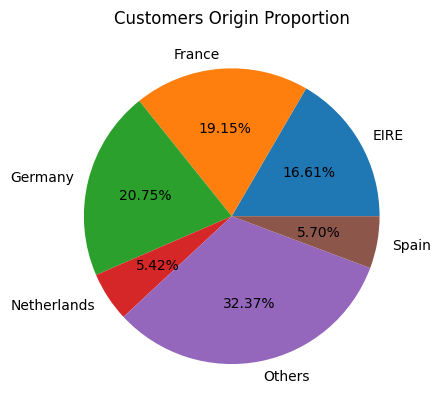

In [ ]:
# Simplify country origin
customers_origin = df_nonUK.groupby(['Country']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from Germany, France, and Eire.

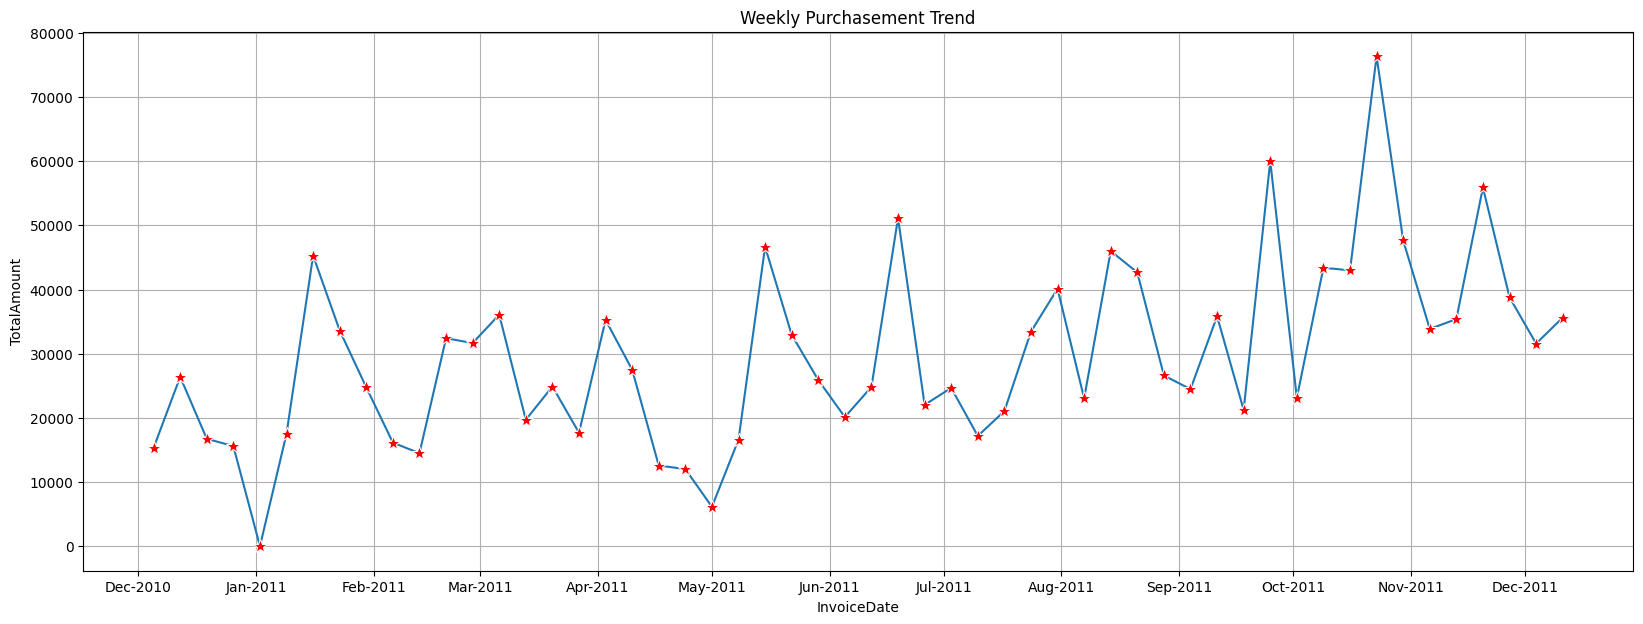

In [ ]:
# Plot weekly trend
weekly_purchasements = df_nonUK.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

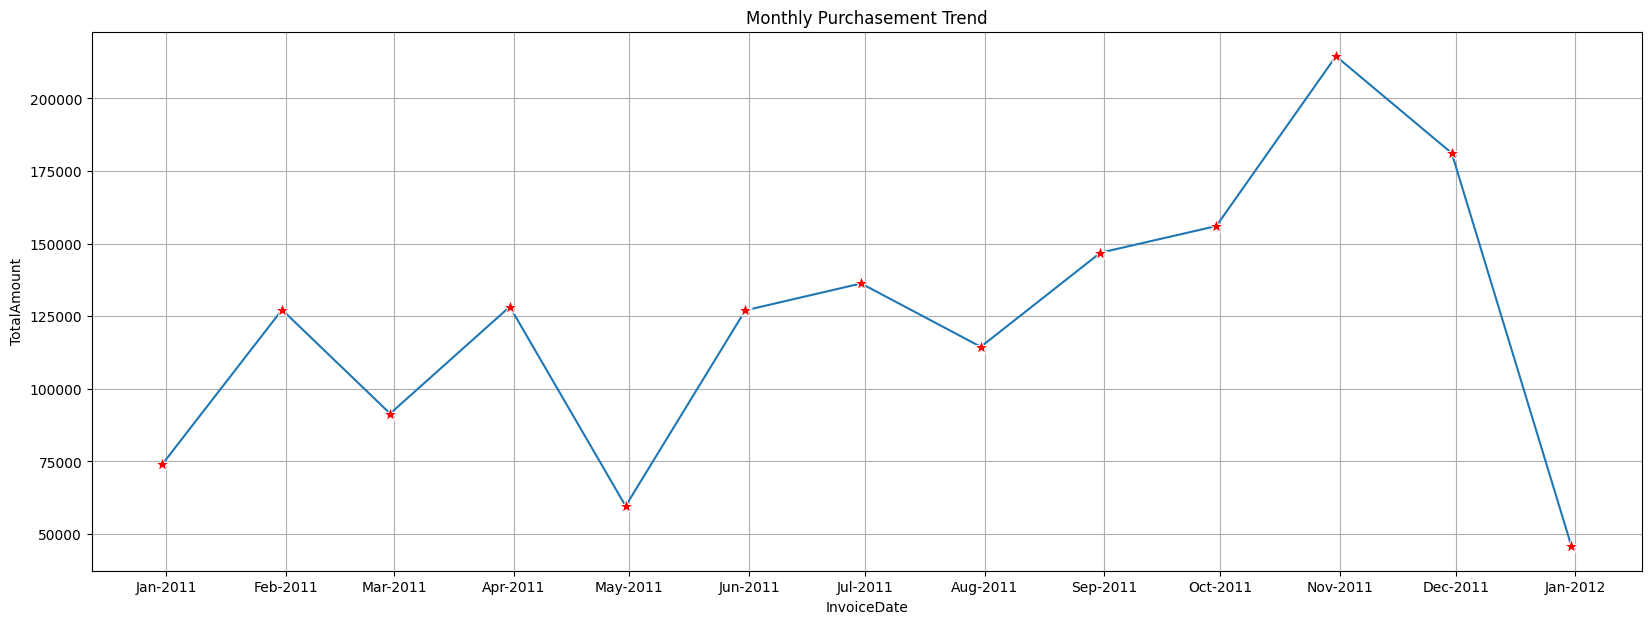

In [ ]:
# Plot monthly trend
monthly_purchasements = df_nonUK.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases until November but decreasing on December. This is understandable since we only have data last updated data we have is for 9th December 2011.

In [ ]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df_nonUK.groupby("CustomerID")["InvoiceDate"].max()
recency = recency.max() - recency
recency = recency.dt.days
recency = recency.rename("Recency")

recency.head()

CustomerID
12347.0      1
12348.0     74
12349.0     18
12350.0    309
12352.0     35
Name: Recency, dtype: int64

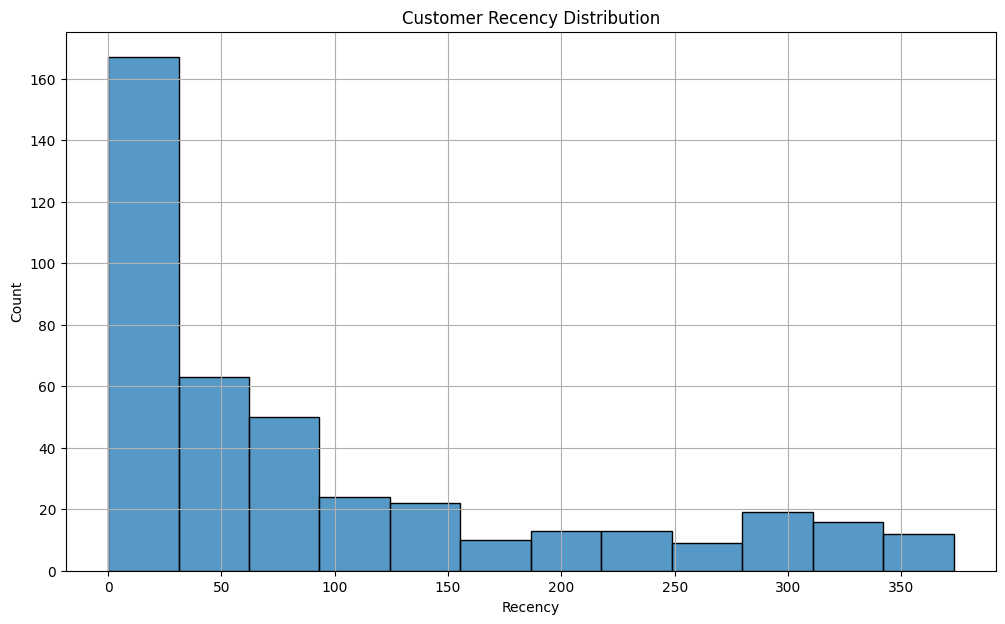

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df_nonUK.groupby("CustomerID")["InvoiceNo"].count()
frequency = frequency.rename("Frequency")

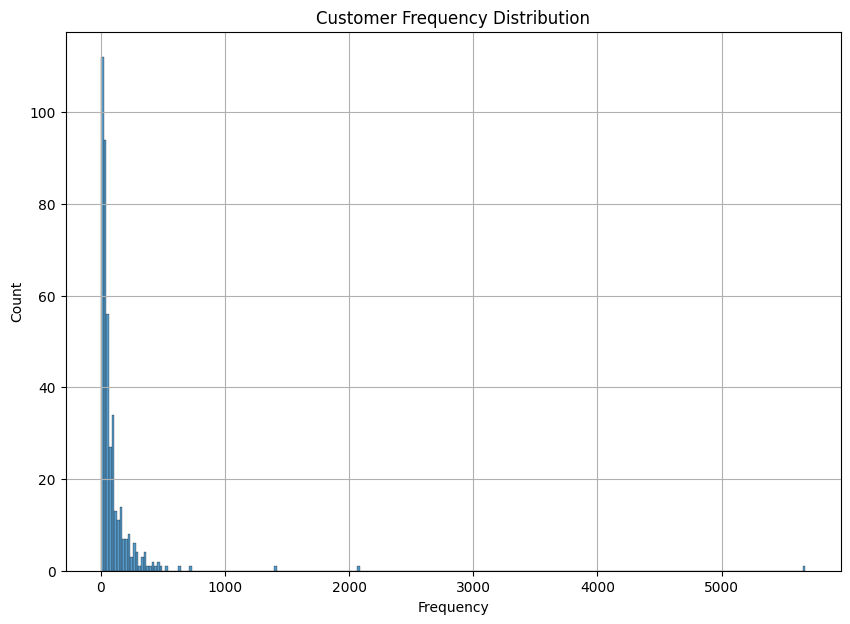

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df_nonUK.groupby("CustomerID")["TotalAmount"].sum()
monetary = monetary.rename("Monetary Spent")

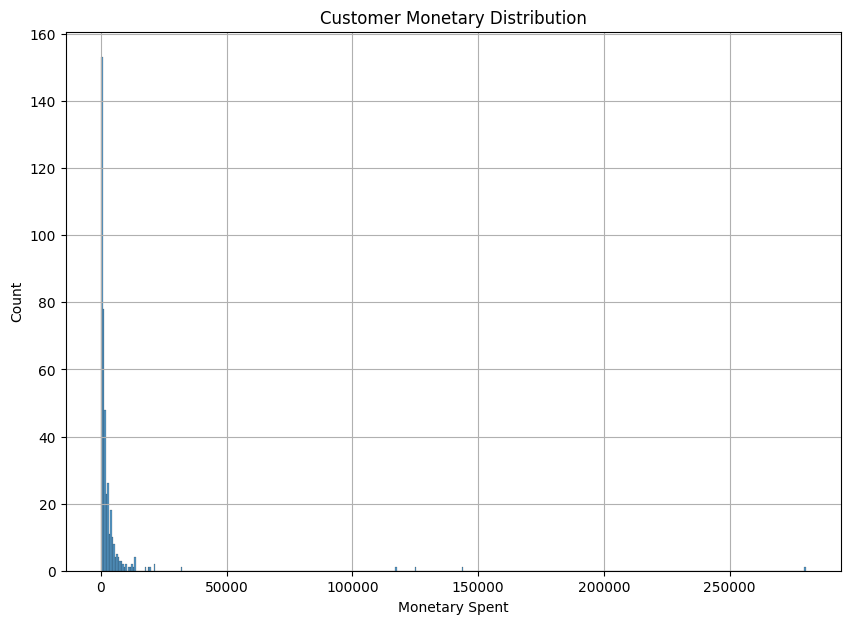

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df_nonUK.groupby(['CustomerID', 'Country'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (country.merge(recency, on="CustomerID").merge(frequency, on="CustomerID").merge(monetary, on="CustomerID"))

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country,Recency,Frequency,Monetary Spent
CustomerID,,,,
12347.0,Others,1,182,4310.00
12348.0,Others,74,31,1797.24
12349.0,Others,18,73,1757.55
12350.0,Others,309,17,334.40
12352.0,Others,35,85,2506.04


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 426 entries, 12347.0 to 17844.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         426 non-null    object 
 1   Recency         426 non-null    int64  
 2   Frequency       426 non-null    int64  
 3   Monetary Spent  426 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 16.6+ KB


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country'],
    drop_first=True
)

df_new.head()

,Recency,Frequency,Monetary Spent,Country_France,Country_Germany,Country_Netherlands,Country_Others,Country_Spain
CustomerID,,,,,,,,
12347.0,1,182,4310.00,0,0,0,1,0
12348.0,74,31,1797.24,0,0,0,1,0
12349.0,18,73,1757.55,0,0,0,1,0
12350.0,309,17,334.40,0,0,0,1,0
12352.0,35,85,2506.04,0,0,0,1,0


### Scaling

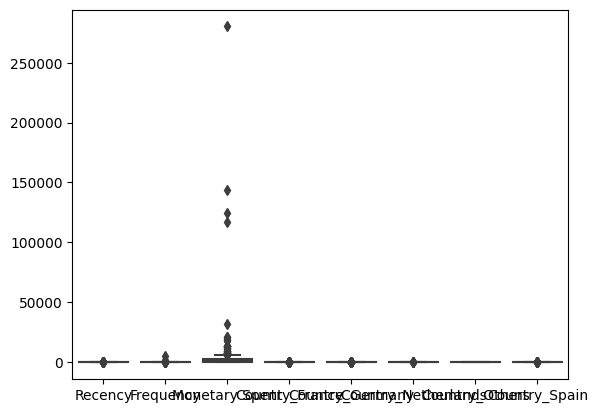

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_France,Country_Germany,Country_Netherlands,Country_Others,Country_Spain
CustomerID,,,,,,,,
12347.0,-0.895242,0.248311,0.027258,-0.511137,-0.536976,-0.147979,1.063945,-0.27735
12348.0,-0.194767,-0.234827,-0.115811,-0.511137,-0.536976,-0.147979,1.063945,-0.27735
12349.0,-0.732117,-0.100444,-0.118071,-0.511137,-0.536976,-0.147979,1.063945,-0.27735
12350.0,2.060186,-0.279621,-0.199101,-0.511137,-0.536976,-0.147979,1.063945,-0.27735
12352.0,-0.568993,-0.062049,-0.075454,-0.511137,-0.536976,-0.147979,1.063945,-0.27735


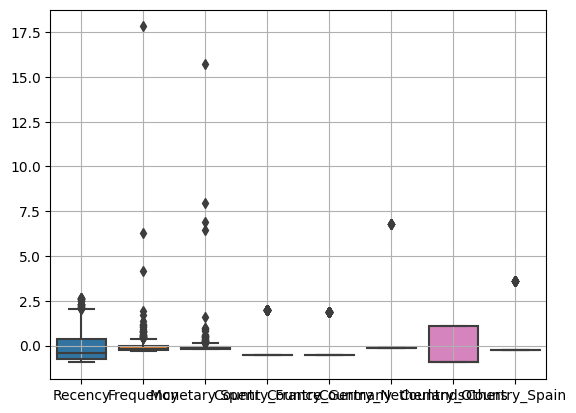

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

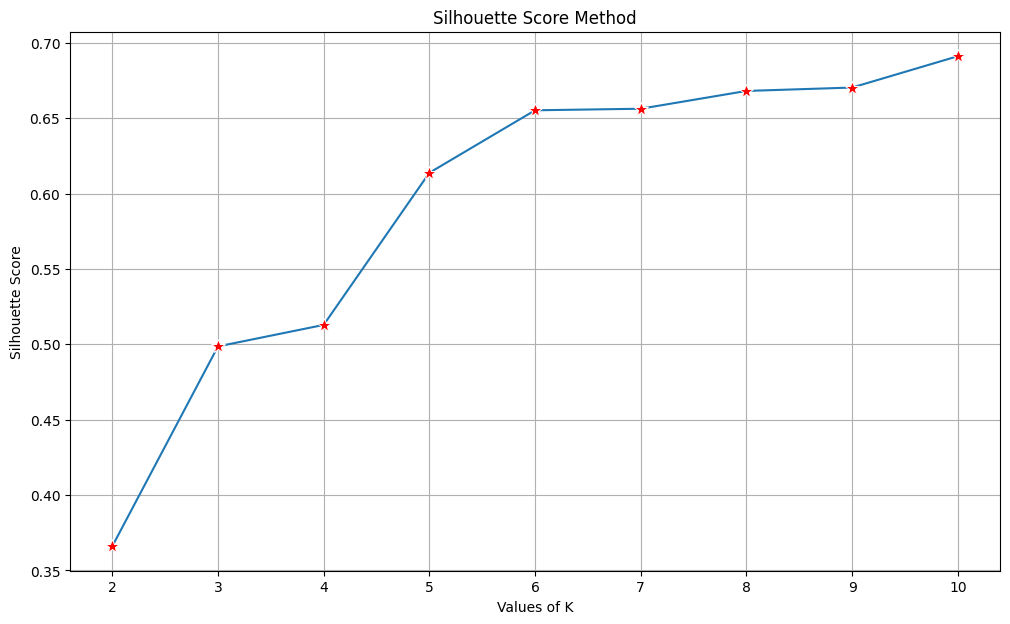

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is 5 or more

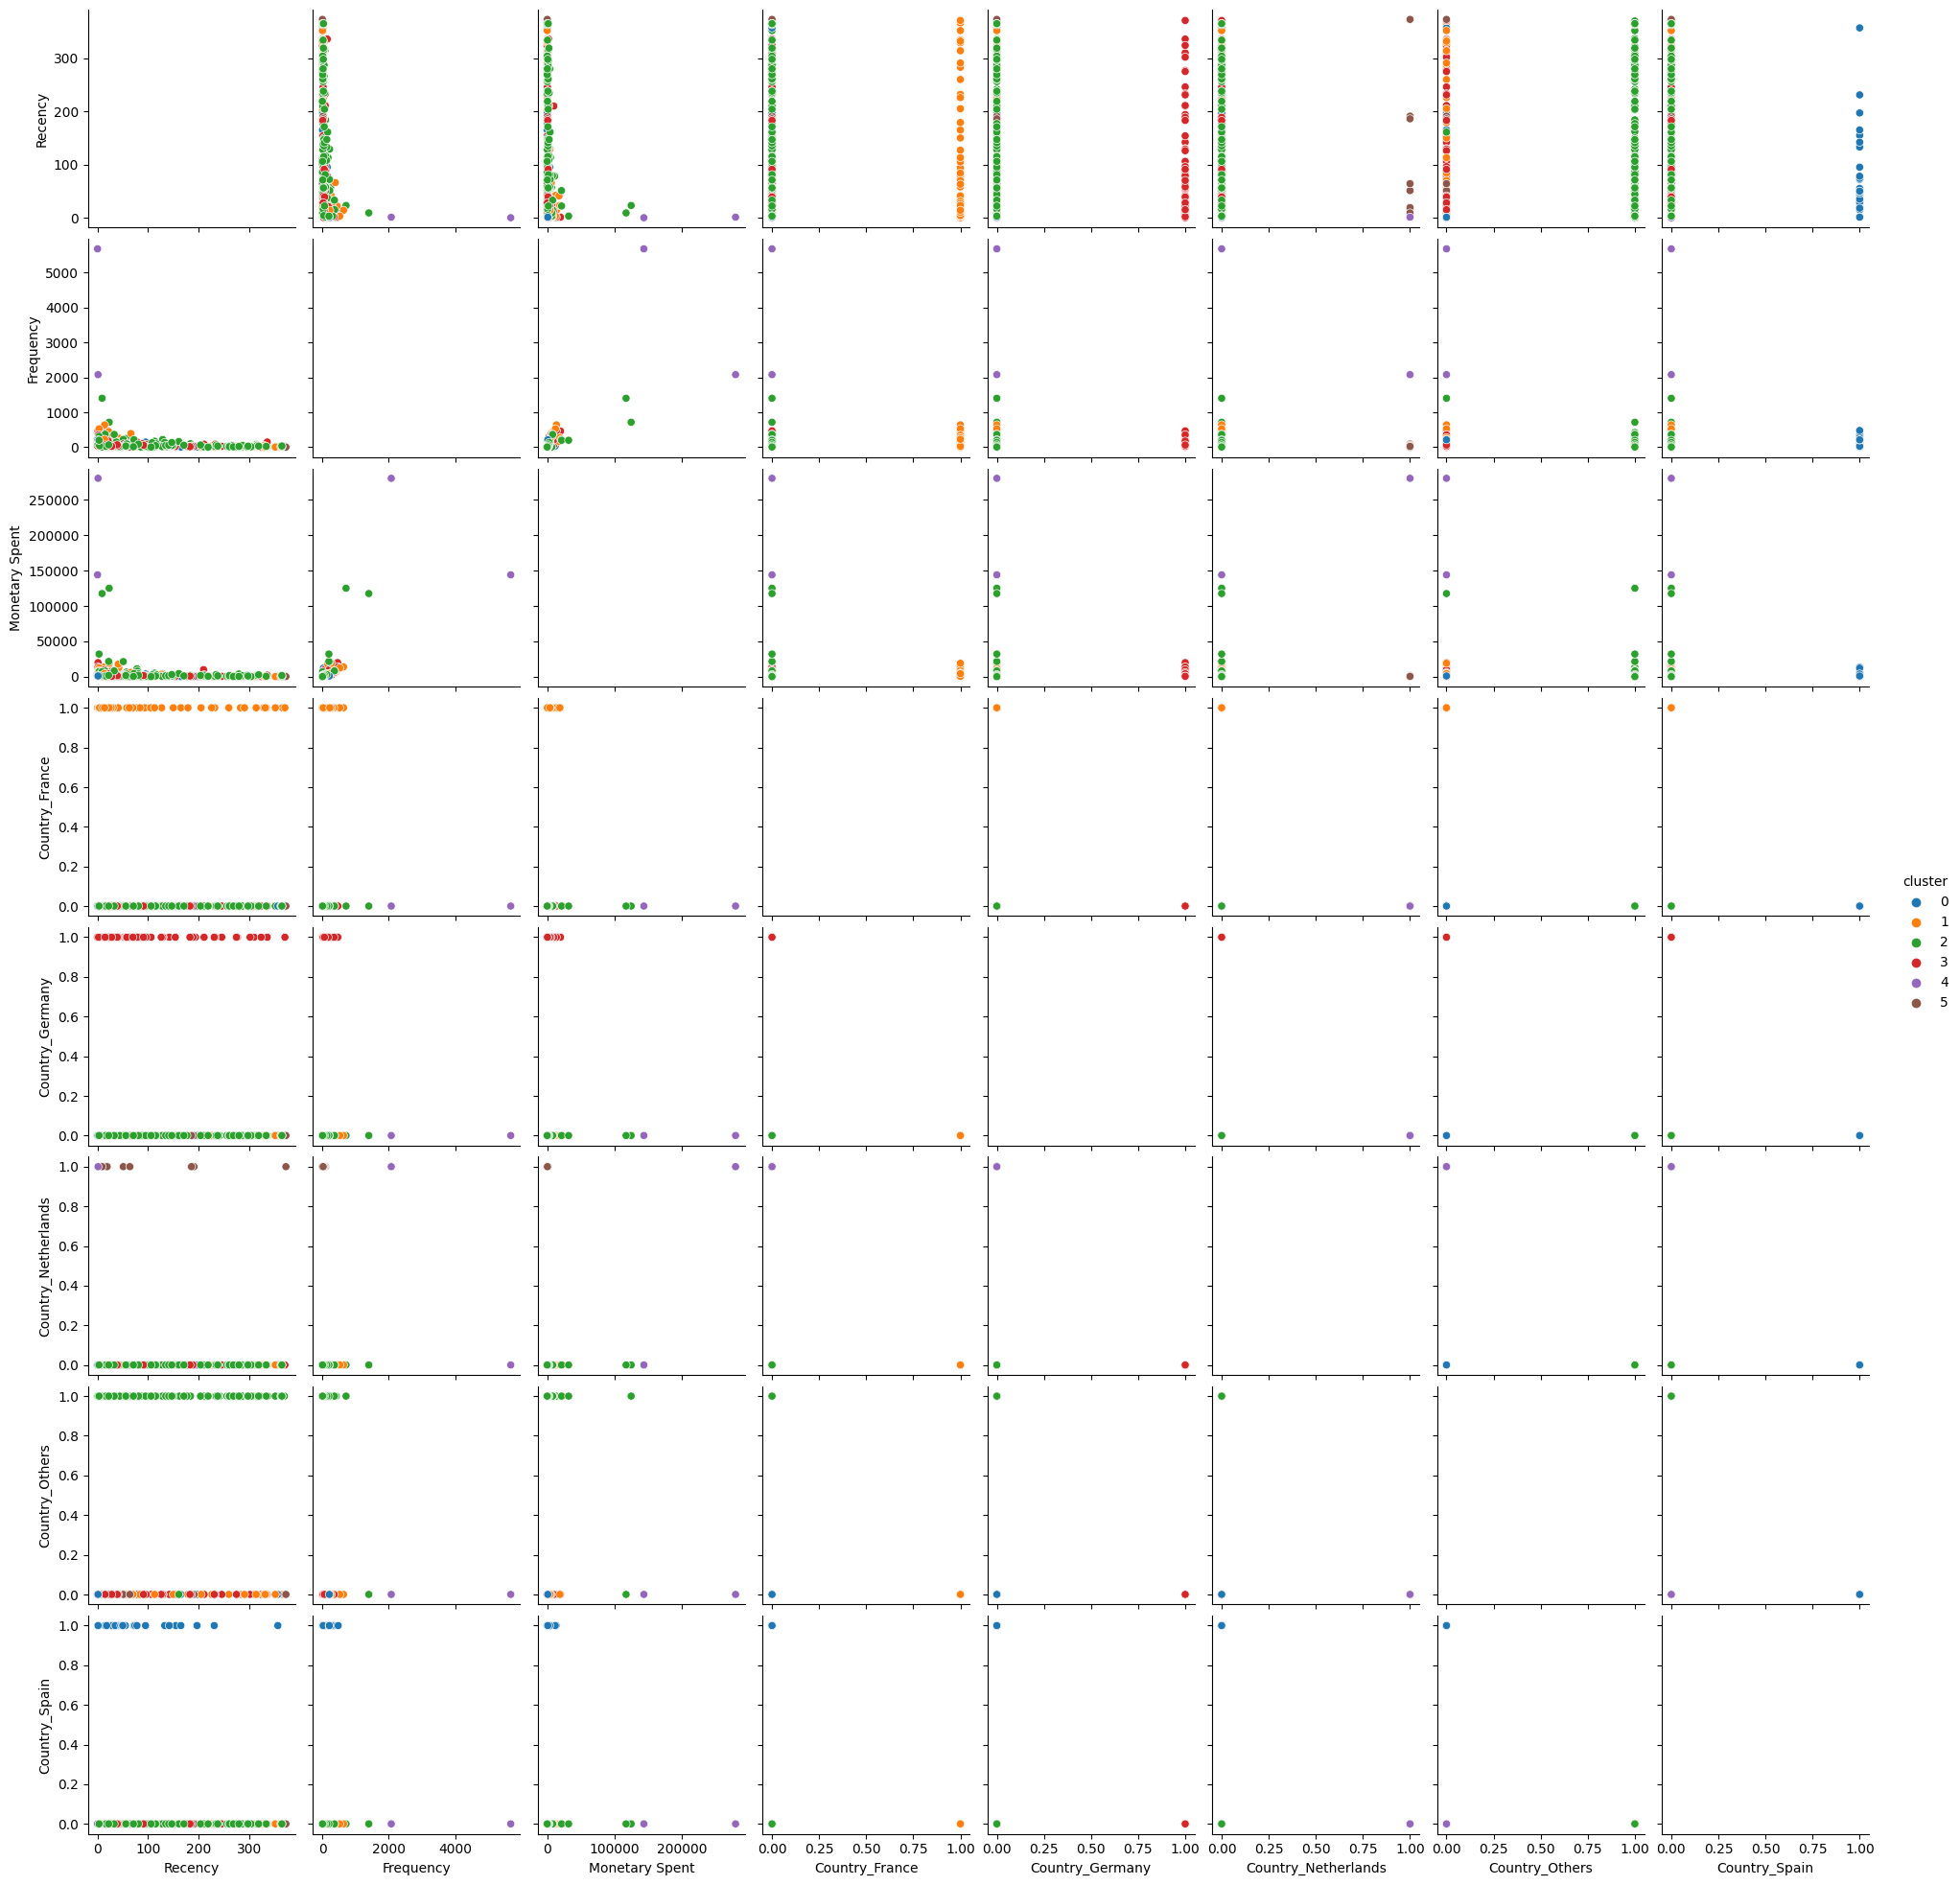

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans[["Recency", "Frequency", "Monetary Spent", "cluster"]]
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0             1              2  \
Recency        mean       73.266667     88.528736     108.487437   
               std        81.275578    112.025624     107.603596   
               min         1.000000      0.000000       0.000000   
               q25        19.500000     10.000000      22.000000   
               median     44.500000     31.000000      65.000000   
               q75        90.750000    110.000000     161.500000   
               max       357.000000    371.000000     370.000000   
Frequency      mean       89.833333     95.873563      79.070352   
               std       113.944658    119.321025     128.202787   
               min         4.000000      4.000000       1.000000   
               q25        19.500000     23.500000      22.000000   
               median     47.500000     47.000000      43.000000   
               q75       113.250000    125.000000      95.500000   
               max       478.000000    638.000000    1400.000000   
Monetary Spent mean     2216.293667   2402.575287    3394.376432   
               std      3217.992039   3733.262981   12416.106460   
               min        95.200000     73.500000      51.560000   
               q25       391.887500    408.185000     510.185000   
               median    981.875000    862.810000    1226.880000   
               q75      3262.970000   2803.555000    2495.510000   
               max     13400.240000  18895.910000  124914.530000   

cluster                           3              4            5  
Recency        mean       76.659574       0.500000   113.625000  
               std        91.449093       0.707107   127.792172  
               min         0.000000       0.000000     9.000000  
               q25        15.250000       0.250000    18.250000  
               median     30.000000       0.500000    57.500000  
               q75        91.000000       0.750000   187.250000  
               max       371.000000       1.000000   373.000000  
Frequency      mean       96.170213    3875.500000    35.375000  
               std       106.762790    2544.877305    32.416651  
               min         2.000000    2076.000000     2.000000  
               q25        23.250000    2975.750000    16.000000  
               median     55.000000    3875.500000    23.000000  
               q75       141.250000    4775.250000    54.000000  
               max       467.000000    5675.000000    95.000000  
Monetary Spent mean     2434.756809  212015.540000   655.040000  
               std      3268.239206   96435.901641   542.318799  
               min        63.000000  143825.060000    91.850000  
               q25       530.150000  177920.300000   291.840000  
               median   1066.140000  212015.540000   445.620000  
               q75      3328.692500  246110.780000   963.182500  
               max     19824.050000  280206.020000  1531.440000

In [ ]:
df_result_kmeans.columns

Index(['Recency', 'Frequency', 'Monetary Spent', 'Country_France',
       'Country_Germany', 'Country_Netherlands', 'Country_Others',
       'Country_Spain', 'cluster'],
      dtype='object')

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_France", "Country_Germany", 'Country_Netherlands', 'Country_Others',
       'Country_Spain'])["Recency"].count()

cluster  Country_France  Country_Germany  Country_Netherlands  Country_Others  Country_Spain
0        0               0                0                    0               1                 30
1        1               0                0                    0               0                 87
2        0               0                0                    0               0                  2
                                                               1               0                197
3        0               1                0                    0               0                 94
4        0               0                0                    0               0                  1
                                          1                    0               0                  1
5        0               0                1                    0               0                  8
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

*   Cluster 4 terdiri dari pelanggan - pelanggan yang memiliki tingkat recency sangat kecil dengan tingkat frequency dan monetary spent sangat besar jika dibandingkan dengan cluster lainnya
*   cluster 5 adalah cluster dengan pelanggan yang memiliki tingkat recency sangat tinggi dengan tingkat frequency dan monetary sangat rendah jika dibandingkan dengan cluster lainnya

*   cluster 0 saat ini terdiri dari semua pelanggan yang berasal dari spain
*   cluster 1 saat ini terdiri dari semua pelanggan yang berasal dari france


*   cluster 3 saat ini terdiri dari semua pelanggan yang berasal dari germany


